###0._Memoria.

In [ ]:
#GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sat Mar 19 15:36:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###1._Carga del conjunto de datos
###Kaggle data.
https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

In [ ]:
#Preparando el dataset.
!pip install --upgrade --force-reinstall --no-deps kaggle
#%%capture
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 58 kB 4.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=fe38893b2f87ef37b62f721851952bcea58d5c1e286116373627f21206d16e6a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json


In [ ]:
#mendeley dataset
#https://www.kaggle.com/paultimothymooney/breast-histopathology-images
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 99% 3.08G/3.10G [00:27<00:00, 171MB/s]
100% 3.10G/3.10G [00:27<00:00, 122MB/s]


In [ ]:
%%capture
#unzip -d target_directory zip_file
!unzip -d '/content/breast/' breast-histopathology-images.zip

In [ ]:
path_A = '/content/breast/8864/0'
path_B = '/content/breast/8864/1'

In [ ]:
#librerias
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from keras.models import Sequential
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout
import matplotlib.pyplot as plt
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [ ]:
#creando el set de entrenamiento.
def my_set(path, size, SPATIAL_DIM):
  X = np.empty(shape=(size, SPATIAL_DIM, SPATIAL_DIM, 3))
  i = 0
  for directory_path in glob.glob(path):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
      img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
      img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
      img = np.flip(img, axis=2)
      X[i] = img
      i += 1
  print('Set.shape:',X.shape)
  return X

In [ ]:
print('x1.shape:')
x1 = my_set(path_A, size=805, SPATIAL_DIM=128)
print('x2.shape:')
x2 = my_set(path_B, size=328, SPATIAL_DIM=128)

x1.shape:
Set.shape: (805, 128, 128, 3)
x2.shape:
Set.shape: (328, 128, 128, 3)


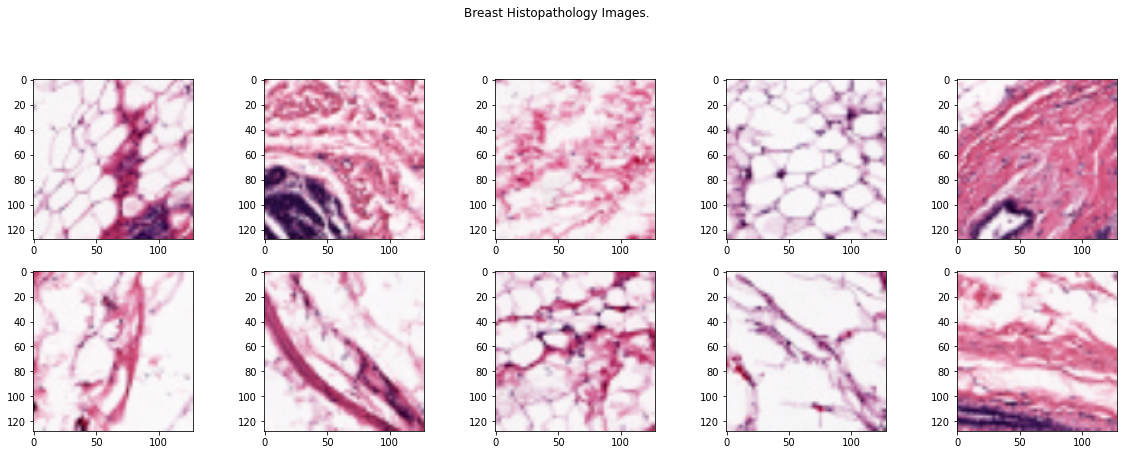

In [ ]:
from google.colab import output
view = x1[:10]
#print(view.shape)
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(view):
    plt.subplot(len(view) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    plt.suptitle("Breast Histopathology Images.")
    output.clear()

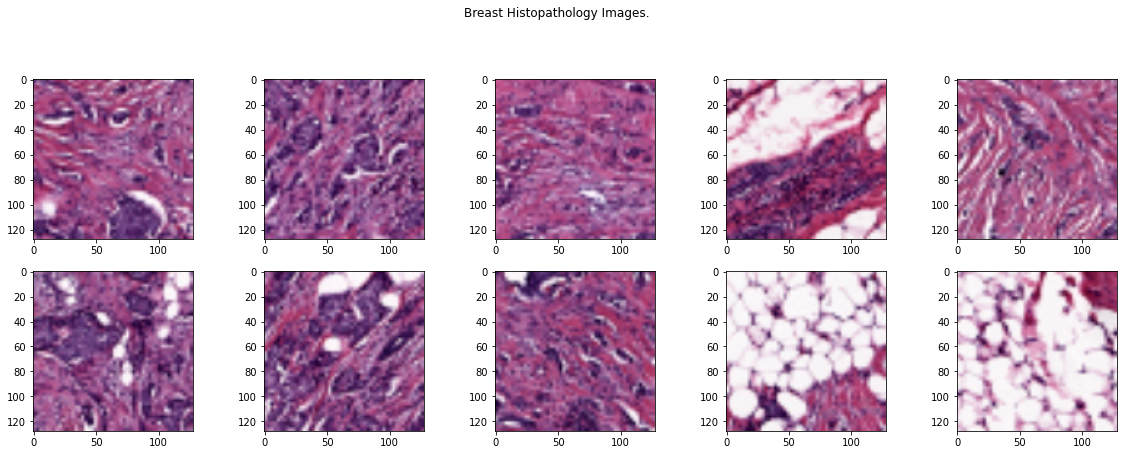

In [ ]:
from google.colab import output
view = x2[:10]
#print(view.shape)
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(view):
    plt.subplot(len(view) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    plt.suptitle("Breast Histopathology Images.")
    output.clear()

In [ ]:
#GAN
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Conv2DTranspose, Activation, LeakyReLU, Concatenate
from keras.initializers import RandomNormal
# install keras.contrib with the InstanceNormalization layer
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ienvig2q
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ienvig2q
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=e66f1cba8cb337b40ece7bdaacff05fd9eb3abdaad0dc225985e0b84b99e1bf1
  Stored in directory: /tmp/pip-ephem-wheel-cache-31p31puw/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
# import the new instance normalization layer
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
# create the discriminator for the GAN
def discriminator(input_shape):
    # kernel initializer for our layers
    init = RandomNormal(stddev = 0.02)
    # image input
    inputs = Input(shape = input_shape)
    # first conv layer with 32 filters
    x = Conv2D(16, 5, 2, padding='same', kernel_initializer=init, name='conv_0')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    # conv layers with instance normalization
    x = Conv2D(32, 5, 2, padding='same', kernel_initializer=init, name='conv_1')(x)
    x = InstanceNormalization(axis=-1)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(64, 5, 2, padding='same', kernel_initializer=init, name='conv_2')(x)
    x = InstanceNormalization(axis=-1)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, 5, 2, padding='same', kernel_initializer=init, name='conv_3')(x)
    x = InstanceNormalization(axis=-1)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, 5, padding='same', kernel_initializer=init, name='conv_5')(x)
    x = InstanceNormalization(axis=-1)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # output layer
    outputs = Conv2D(1, 5, padding='same', kernel_initializer=init, name='output')(x)
    # define the discriminator
    model = Model(inputs, outputs)
    # compile the model
    model.compile(loss='mse', optimizer=Adam(lr=0.0001, beta_1=0.5))
    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


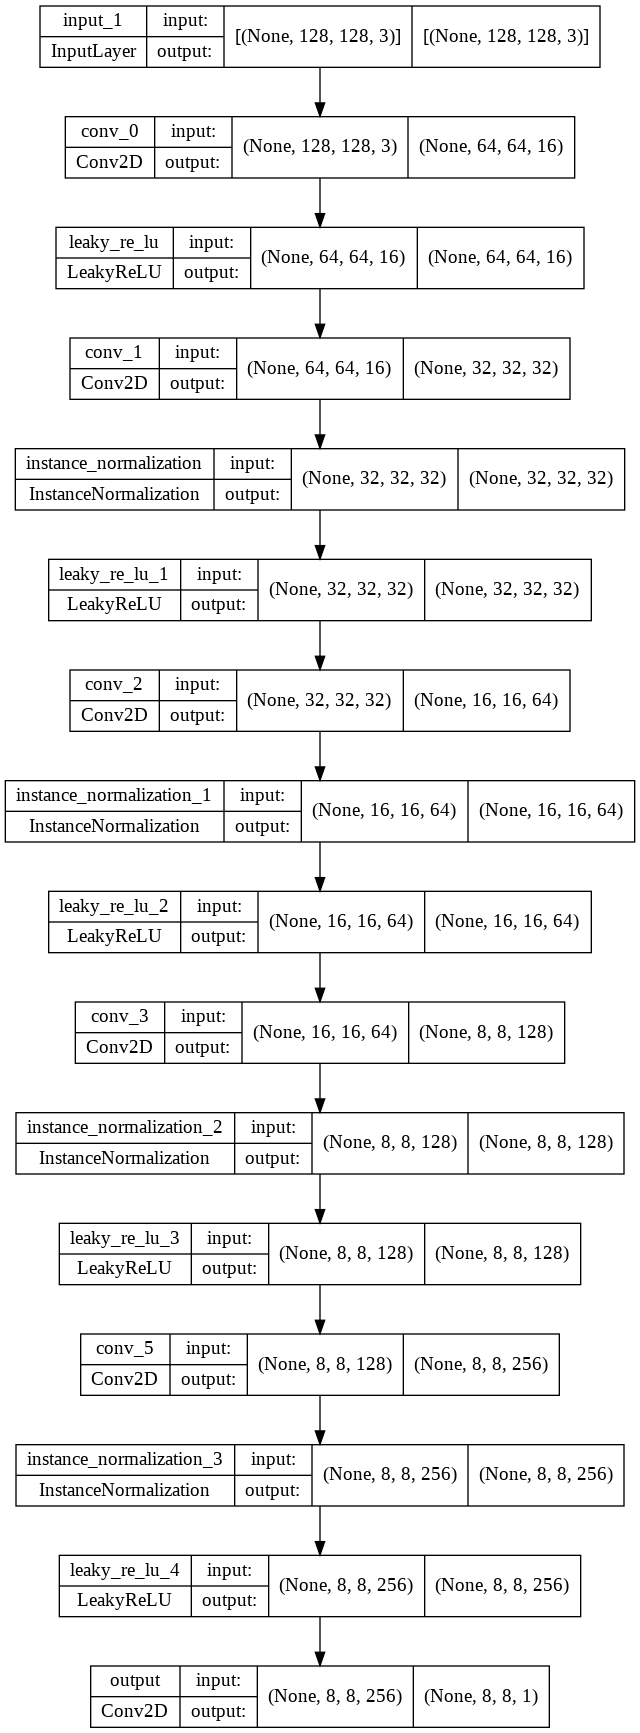

In [ ]:
# define image shape constant
IMG_SHAPE = (128, 128, 3)
# declare the model
model = discriminator(IMG_SHAPE)
# model summary
#model.summary()
plot_model(model, to_file='dis.png', show_shapes=True)

In [ ]:
# create residual blocks for the generator
def res_block(filters, inputs):
    # kernel weights initializer
    init = RandomNormal(stddev=0.02)
    x = Conv2D(filters, 3, padding='same', kernel_initializer=init)(inputs)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('selu')(x)
    x = Conv2D(filters, 3, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    # concatenate second conv layer with the inputs
    x = Concatenate()([x, inputs])
    return x

In [ ]:
# generator function
def generator(img_shape = (128, 128, 3), n_blocks = 8):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    inputs = Input(shape = (128, 128, 3))
    x = Conv2D(16, 5, padding='same', kernel_initializer=init)(inputs)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('selu')(x)
    
    x = Conv2D(32, 3, 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('selu')(x)
    
    x = Conv2D(64, 3, 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('selu')(x)
    
    # add residual blocks to our generator
    for _ in range(n_blocks):
        x = res_block(128, x)
    
    # transpose convolutions
    x = Conv2DTranspose(32, 3, strides = 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('selu')(x)
    
    x = Conv2DTranspose(64, 3, 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('selu')(x)
    
    # output layer
    x = Conv2D(3, 7, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    outputs = Activation('tanh')(x)
    
    # create the model
    model = Model(inputs, outputs)
    return model

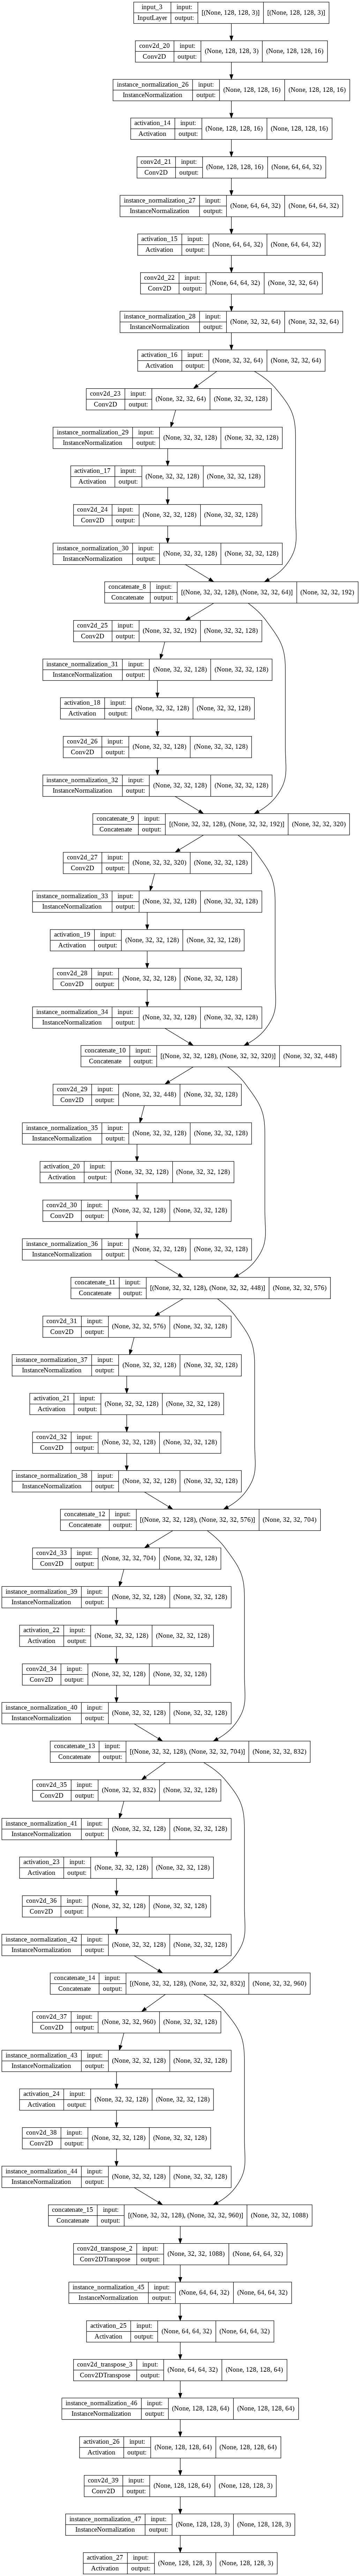

In [ ]:
model = generator()
# model summary
#model.summary()
plot_model(model, to_file='gen.png', show_shapes=True)

In [ ]:
# define the two generators and two discriminators for CycleGAN
generator_BtoA = generator(IMG_SHAPE)
generator_AtoB = generator(IMG_SHAPE)
discriminator_A = discriminator(IMG_SHAPE)
discriminator_B = discriminator(IMG_SHAPE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# define composite model
def composite_model(g1, d1, g2, image_shape):
    # mark the first generator as trainable
	g1.trainable = True
	# freeze discriminator
	d1.trainable = False
	# freeze second generator
	g2.trainable = False
	input_gen = Input(shape=image_shape)
	gen1_out = g1(input_gen)
	output_d = d1(gen1_out)
	input_id = Input(shape=image_shape)
	output_id = g1(input_id)
	output_f = g2(gen1_out)
	gen2_out = g2(input_id)
	output_b = g1(gen2_out)
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	optimizer = Adam(lr=0.0001, beta_1=0.5)
	# compile model with L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=optimizer)
	return model

In [ ]:
# scale the data to -1 and 1
X1 = (x1.astype("float") - 127.5) / 127.5
X2 = (x2.astype("float") - 127.5) / 127.5
print('X1.shape:',X1.shape)
print('X2.shape:',X2.shape)

X1.shape: (805, 128, 128, 3)
X2.shape: (328, 128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TRANSLATED IMAGE WITHOUT TRAINING


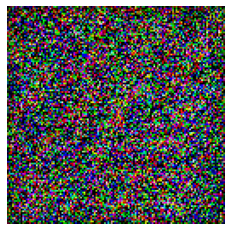

In [ ]:
# translate an image without training
plt.axis(False)
translation = generator_BtoA(np.reshape(X2[1], (1, 128, 128, 3)))
print('TRANSLATED IMAGE WITHOUT TRAINING')
plt.imshow(np.reshape(translation, (128, 128, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ORIGINAL IMAGE


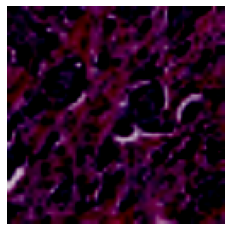

In [ ]:
print('ORIGINAL IMAGE')
plt.axis(False)
plt.imshow(X2[1])

In [ ]:
from numpy.random import randint
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate fake images (batch size)
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate the image
	X = g_model(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

def summarize_performance(step, g_model, trainX, name, n_samples=5):
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate target images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# rescale to 0 - 1
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
	# plot target image
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	plt.savefig(filename1)
	plt.close()

In [ ]:
# create a pool of fake images to trace the training
from random import random
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)

In [ ]:
# train the cycleGAN models for 50 epochs with a batch size of 1
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    # train for 10 epochs
	n_epochs, n_batch, = 10, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate fake images
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')

In [ ]:
# create the composite model for A to B
composite_AtoB = composite_model(generator_AtoB, discriminator_B,generator_BtoA, IMG_SHAPE)
composite_BtoA = composite_model(generator_BtoA, discriminator_A, generator_AtoB, IMG_SHAPE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# finally, train the model
train(discriminator_A, discriminator_B, generator_AtoB,generator_BtoA,  composite_AtoB,
     composite_BtoA, [X1, X2])

Se han truncado las últimas 5000 líneas del flujo de salida.
>3051, dA[0.016,0.029] dB[0.003,0.005] g[8.541,9.681]
>3052, dA[0.006,0.004] dB[0.002,0.008] g[5.871,7.565]
>3053, dA[0.004,0.010] dB[0.003,0.006] g[6.827,8.511]
>3054, dA[0.436,0.069] dB[0.003,0.009] g[5.009,5.989]
>3055, dA[0.163,0.254] dB[0.003,0.005] g[4.454,4.049]
>3056, dA[0.048,0.050] dB[0.003,0.010] g[7.200,8.564]
>3057, dA[0.920,0.243] dB[0.003,0.005] g[11.068,9.479]
>3058, dA[0.070,0.083] dB[0.110,0.014] g[7.320,7.738]
>3059, dA[0.391,0.087] dB[0.022,0.061] g[4.738,5.414]
>3060, dA[0.040,0.219] dB[0.007,0.036] g[4.708,4.232]
>3061, dA[0.032,0.006] dB[0.033,0.013] g[7.620,7.862]
>3062, dA[0.066,0.015] dB[0.016,0.013] g[4.581,4.918]
>3063, dA[0.006,0.034] dB[0.009,0.032] g[5.824,6.700]
>3064, dA[0.003,0.004] dB[0.007,0.017] g[5.202,5.808]
>3065, dA[0.044,0.027] dB[0.003,0.007] g[5.556,5.881]
>3066, dA[0.053,0.055] dB[0.005,0.027] g[4.327,4.331]
>3067, dA[0.008,0.007] dB[0.006,0.026] g[6.425,8.194]
>3068, dA[0.030,0.02

In [ ]:
# save the model
generator_BtoA.save('translator.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


foto #: 2


Text(0.5, 0.98, 'Histopatologic and translated Image #: 2')

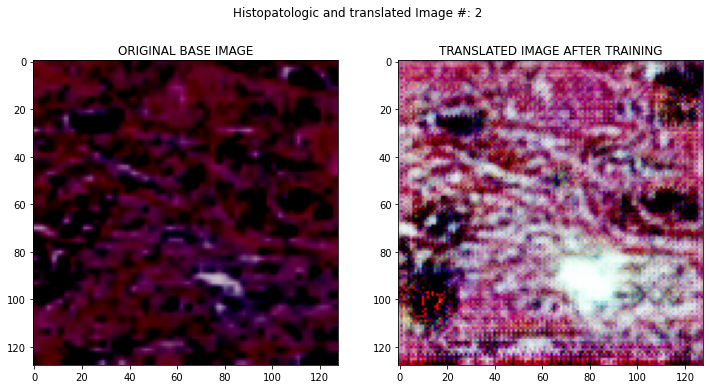

In [ ]:
#Testing...
import random
#hasta 328
foto = 2
#foto = random.randint(0,len(X2))
print('foto #:',foto)
translation = generator_BtoA(np.reshape(X2[foto], (1, 128, 128, 3)))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('ORIGINAL BASE IMAGE')
plt.imshow(X2[foto])
plt.subplot(122)
plt.title('TRANSLATED IMAGE AFTER TRAINING')
plt.imshow(np.reshape(translation, (128, 128, 3)))
plt.suptitle('Histopatologic and translated Image #: '+str(foto))